In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import sys
import os
# import warnings
# warnings.filterwarnings('ignore')

#user = 'madams01'
#sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
sys.path.append("/home/ishah/ipynb/ml-tox/src")
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
#from mltox.db.graph_utils import *

import functools
import seaborn as sns

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES']=''
!CUDA_VISIBLE_DEVICES='0'
!export CUDA_VISIBLE_DEVICES
os.getenv('CUDA_VISIBLE_DEVICES')


# Data

In [3]:
GNR = openMongo(db='genra_dev_v5',auth=False,host='localhost')

## ATG

In [4]:
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
CH_ATG

,dsstox_sid,smiles,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,DTXSID0020232,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,DTXSID0020236,[Ca++].CC(O)C([O-])=O.CC(O)C([O-])=O,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,DTXSID0020280,[O-][N+](=O)C1=C(Cl)C=CC=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,DTXSID0020282,NC1=CC(N)=C(Cl)C=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID0020284,OS(O)(=O)=O.NC1=CC=C(N)C(Cl)=C1,1,0,1,1,0,0,1,1,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,DTXSID9051907,COC1=NC=CN=C1CC(C)C,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3475,DTXSID9052505,CCCCC(C)=C,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3476,DTXSID9052509,OC1=CC=C(C=C1)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3477,DTXSID9052846,COCC(C)N(C(=O)CS(O)(=O)=O)C1=CSC=C1C,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
CHM = pd.DataFrame(GNR.compounds.find(dict(dsstox_sid={'$in':CH_ATG.dsstox_sid.tolist()}),
                                     dict(_id=0,dsstox_sid=1,name=1))).set_index('dsstox_sid')
CHM.head()

,name
dsstox_sid,
DTXSID0020232,Caffeine
DTXSID0020236,Calcium lactate
DTXSID0020280,1-Chloro-2-nitrobenzene
DTXSID0020282,"4-Chloro-1,3-diaminobenzene"
DTXSID0020284,"2-Chloro-1,4-diaminobenzene sulfate (1:1)"


In [248]:
CHM.shape

(3479, 1)

In [6]:
'DTXSID9047203' in CH_ATG.dsstox_sid.tolist(),\
'DTXSID9022445' in CH_ATG.dsstox_sid.tolist(),\
'DTXSID0020232' in CH_ATG.dsstox_sid.tolist()

(True, True, True)

## ER


In [7]:
ER1 = pd.read_csv('/home/ishah/ipynb/ml-tox/data/bio/ER-pmi.csv')

In [8]:
ER1_pos = ER1[(ER1.er_class.isin([1])) & (ER1.ESR1_coc>=40) & (ER1.er_class==1)]
X=ER1_pos.sort_values('ESR1_pmi',ascending=False).head(20)
SID_pos = X.dtxsid.tolist()
ER1_neg = ER1[(ER1.er_class.isin([0])) & (ER1.n_chem>=1e3) & (ER1.ESR1_pmi<=0) & (ER1.er_class==0)]
X = ER1_neg.sort_values('ESR1_pmi',ascending=False).head(20)
SID_neg = X.dtxsid.tolist()


In [9]:
len(SID_pos),len(SID_neg)

(20, 20)

## TSCA

In [30]:
TSCAs=pd.read_excel("/home/ishah/ipynb/ml-tox/data/chm/NCCRP_picklist_round2_refchem_reps.xlsx",
                   sheet_name="Main Data")
TSCAs.head()

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,SMILES,AVERAGE_MASS,TOXVAL_DATA,NUMBER_OF_PUBMED_ARTICLES,BIOCONCENTRATION_FACTOR_TEST_PRED,...,HENRYS_LAW_ATM-M3/MOLE_OPERA_PRED,OPERA_KM_DAYS_OPERA_PRED,OCTANOL_AIR_PARTITION_COEFF_LOGKOA_OPERA_PRED,SOIL_ADSORPTION_COEFFICIENT_KOC_L/KG_OPERA_PRED,OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED,MELTING_POINT_DEGC_OPERA_PRED,OPERA_PKAA_OPERA_PRED,OPERA_PKAB_OPERA_PRED,VAPOR_PRESSURE_MMHG_OPERA_PRED,WATER_SOLUBILITY_MOL/L_OPERA_PRED
0,DTXSID7059777,DSSTox_Substance_Id,DTXSID7059777,Pyridazine,289-80-5,C1=CC=NN=C1,80.090,Y,142,2.0797,...,0.000005,0.086988,3.18728,14.2198,-0.717987,-7.58946,,2.33,6.92946,12.5057
1,DTXSID8061719,DSSTox_Substance_Id,DTXSID8061719,"1-Propene, 3-isocyanato-",1476-23-9,C=CCN=C=O,83.090,Y,,,...,0.00001,0.161631,2.18869,17.539,-0.404367,47.8159,,,46.9514,0.420097
2,DTXSID1062752,DSSTox_Substance_Id,DTXSID1062752,"3-Butyn-2-amine, 2-methyl-",2978-58-7,CC(C)(N)C#C,83.134,Y,,,...,0.000016,0.116529,3.86175,13.2631,-1.37423,17.8554,,,0.112682,9.68152
3,DTXSID1062178,DSSTox_Substance_Id,DTXSID1062178,4-Pentenal,2100-17-6,C=CCCC=O,84.118,Y,,,...,0.00008,0.163042,3.05929,15.7011,1.01698,-64.9172,,,37.6301,0.368177
4,DTXSID8059390,DSSTox_Substance_Id,DTXSID8059390,2-Aminoethyl(ethyl)amine,110-72-5,CCNCCN,88.154,,,0.843335,...,0.0,0.064793,6.91964,11.6644,0.245329,29.4668,,10.46,0.218272,9.8481


In [10]:
sdf = "/home/ishah/ipynb/ml-tox/data/chm/TSCA_JUL22_v3_QSAR-ready_kek.sdf"

In [11]:
from rdkit.Chem import PandasTools

TSCA0 = PandasTools.LoadSDF(sdf, embedProps=True)


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - unable to change molecule rendering


In [12]:
TSCA0.head()
TSCA1 = TSCA0[['Original_SMILES','ID']].rename(columns=dict(Original_SMILES='smiles',ID ='dtxsid'))

In [13]:
TSCA1.head()

,smiles,dtxsid
0,C1=CC=CC=C1C(C1C=CC=CC=1)C1C=CC=CC=1,DTXSID3060164
1,ICCCI,DTXSID7060837
2,OC(=O)C=CC1C=CC(C=CC(O)=O)=CC=1,DTXSID9025879
3,O=C(NC1=CC2=C(NC3C4=C(C=CC2=3)C(=O)C2C(=CC=CC=...,DTXSID2026282
4,CC1(C)COC(C)(OC1)C1C=CC=CC=1,DTXSID4052188


In [14]:
def keepChem(DSa):
    Keep=[]
    for i,v in enumerate(DSa.X):
        #print(i.num_nodes)
        try:
            n = v.num_nodes
        except:
            print(i)
        else:
            Keep.append(i)
    
    return DSa.select(Keep),Keep
    

In [15]:
import deepchem as dc
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
Y_names = CH_ATG.columns[2:]



DS_full = dc.data.NumpyDataset(CH_ATG.smiles,CH_ATG.iloc[:,2:])
FT = dc.trans.FeaturizationTransformer(DS_full, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_full = FT.transform(DS_full)
DS_full,SID_keep = keepChem(DS_full)



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-14 18:31:46.636585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 18:31:46.636654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 18:31:46.637995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 18:3

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Failed to featurize datapoint 244, [Br-].[Br-].[Ca+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 272, [Cl-].[Cl-].[Cl-].[Yb+3]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 913, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 932, [I-].[Na+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1505, [Cl-].[Cl-].[Pd+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1769, [Cl-].[Cl-].[Hg+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1979, [Cu+].[I-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 2669, [Cl-].[Cl-].[

244
272
913
932
1505
1769
1979
2669
3040
3341


In [16]:
DS_tsca = dc.data.NumpyDataset(TSCA1.smiles)
FT = dc.trans.FeaturizationTransformer(DS_tsca, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_tsca = FT.transform(DS_tsca)
DS_tsca,SID_tsca = keepChem(DS_tsca)


Failed to featurize datapoint 2084, C.[Li+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 7442, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 10831, C. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Exception message: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13299,) + inhomogeneous part.


2084
7442
10831


In [38]:
CHM_tsca=pd.DataFrame(GNR.compounds.find(dict(dsstox_sid={'$in':TSCA1.dtxsid.tolist()}),
                                         dict(_id=0,dsstox_sid=1,name=1)))\
            .rename(columns=dict(dsstox_sid='dtxsid'))

# AFP

In [38]:
# CH1 = pd.read_csv('/home/ishah/ipynb/ml-tox/data/chm/CCD-Batch-Search_2024-01-05_10_40_53.csv')
# CH1.columns=CH1.columns.str.lower()
# CH1 = CH1[['dtxsid','smiles']].dropna()
# ER2 = ER0.merge(CH1,on='dtxsid')
# CH1.shape,ER0.shape,ER2.shape

In [17]:
import deepchem as dc
from deepchem.models.torch_models import AttentiveFPModel
#import scipy


In [18]:
DS_full

<NumpyDataset X.shape: (3469,), y.shape: (3469, 80), w.shape: (3469, 1), task_names: [ 0  1  2 ... 77 78 79]>

In [19]:
# AFP1 = AttentiveFPModel(mode='classification',                             
#                             n_tasks=DS_train.y.shape[1],
#                             num_layers=2,
#                             graph_feat_size=100,
#                             batch_size=16, 
#                             verbose=True,                            
#                             learning_rate=0.001)
from mltox.ml.attentive_fp_weights import *
MODEL='/home/ishah/ipynb/ml-tox/models/'
AFP1 = AttentiveFPModelWeights(mode='classification', 
                                n_tasks=DS_full.y.shape[1],
                                graph_feat_size=200,
                                batch_size=16, 
                                num_layers = 2,
                                num_timesteps = 2,
                                learning_rate=0.001,
                                model_dir=MODEL+'afp_full/'                                
                                )

AFP1.fit(DS_full,nb_epoch=40)
#AFP1.restore(model_dir=MODEL+'afp_full/')

0.27747249603271484

In [41]:
{i:Y_names.get_loc(i) for i in Y_names[Y_names.str.contains('ER')]}

{'ATG_ERE_CIS': 13,
 'ATG_ERRa_TRANS': 14,
 'ATG_ERRg_TRANS': 15,
 'ATG_ERa_TRANS': 16}

## TSCA Pred

In [20]:
AFP1_pred = AFP1.predict(DS_tsca)

(array([1886., 1185.,  830.,  685.,  618.,  629.,  532.,  497.,  471.,
         437.,  466.,  406.,  427.,  449.,  433.,  526.,  527.,  640.,
         740.,  912.]),
 array([1.97573105e-08, 4.99999821e-02, 9.99999493e-02, 1.49999917e-01,
        1.99999869e-01, 2.49999836e-01, 2.99999803e-01, 3.49999756e-01,
        3.99999738e-01, 4.49999690e-01, 4.99999642e-01, 5.49999595e-01,
        5.99999607e-01, 6.49999559e-01, 6.99999511e-01, 7.49999464e-01,
        7.99999416e-01, 8.49999368e-01, 8.99999380e-01, 9.49999332e-01,
        9.99999285e-01]),
 <BarContainer object of 20 artists>)

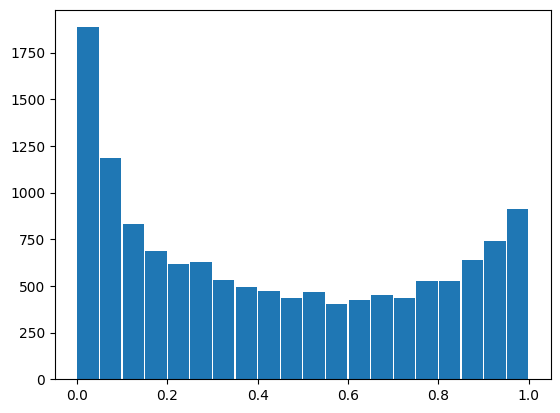

In [27]:
import pylab as pl
pl.hist(AFP1_pred[:,13,1],bins=20,rwidth=0.95)

In [43]:
TSCA_pred = pd.DataFrame({assay:AFP1_pred[:,Y_names.get_loc(assay),1] for assay in Y_names})
TSCA_pred.insert(0,'dtxsid',TSCA1.dtxsid.iloc[SID_tsca])
print(TSCA_pred.shape)
TSCA_pred = CHM_tsca.merge(TSCA_pred,on='dtxsid',how='right')
print(TSCA_pred.shape)

(13296, 81)
(13296, 82)


In [44]:
TSCA_pred.head()

,dtxsid,name,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,DTXSID3060164,Benzhydrylbenzene,0.779710,0.078866,0.060122,0.361214,0.688947,0.690899,0.821583,0.340880,...,0.483177,0.176233,0.231312,0.177881,0.402697,0.051371,0.762570,0.165442,0.355170,0.207589
1,DTXSID7060837,"Propane, 1,3-diiodo-",0.651144,0.018653,0.016655,0.429287,0.238095,0.091101,0.023027,0.023428,...,0.003062,0.162300,0.042953,0.099048,0.754526,0.009011,0.162233,0.005011,0.009590,0.014180
2,DTXSID9025879,"3,3'-(p-Phenylene)diacrylic acid",0.565440,0.136848,0.003519,0.652231,0.391343,0.058177,0.062860,0.021602,...,0.491312,0.006808,0.018646,0.863138,0.021165,0.020885,0.737458,0.038195,0.169650,0.933103
3,DTXSID2026282,C.I. Vat brown 3,0.789356,0.178712,0.012944,0.645679,0.689697,0.755852,0.746685,0.791001,...,0.836622,0.187518,0.852921,0.754918,0.073750,0.531950,0.946755,0.223314,0.802305,0.593171
4,DTXSID4052188,"2,5,5-Trimethyl-2-phenyl-1,3-dioxane",0.604843,0.050259,0.066708,0.290074,0.337627,0.137028,0.729840,0.250290,...,0.190149,0.036441,0.088665,0.037118,0.285498,0.045529,0.570865,0.087767,0.217037,0.209701


In [43]:
# ER_pred0 = pd.DataFrame(dict(dtxsid=CH_ATG.dsstox_sid.iloc[SID_keep],ERa_TRANS_pred=AFP1_pred[:,16,1],
#                            ERE_CIS_pred=AFP1_pred[:,13,1]))
# ER_pred = ER1.merge(ER_pred0,on='dtxsid').drop_duplicates()

# ER_pred.insert(ER_pred.shape[1],'ERa_TRANS_pred_bin', ER_pred.ERa_TRANS_pred.apply(lambda i: 0 if i<0.5 else 1))
# ER_pred.insert(ER_pred.shape[1],'ERE_CIS_pred_bin', ER_pred.ERE_CIS_pred.apply(lambda i: 0 if i<0.5 else 1))
# ER_pred.head()

,dtxsid,refchem_agonist,refchem_antagonist,auc_agonist,er_class,chemical,ESR1_pmi,ESR2_pmi,ESRRA_pmi,ESRRB_pmi,...,ESR1_coc,ESR2_coc,ESRRA_coc,ESRRB_coc,ESRRG_coc,n_chem,ERa_TRANS_pred,ERE_CIS_pred,ERa_TRANS_pred_bin,ERE_CIS_pred_bin
0,DTXSID8022377,moderate,NaN,1.060,1.0,Alfatradiol,0.426793,0.377710,0.000000,0.000000,...,157,16,0,0,0,485,0.884233,0.860397,1,1
1,DTXSID5020576,strong,inactive,1.000,1.0,Ethinyl estradiol,0.324533,0.000000,0.150614,0.052318,...,363,0,1,1,0,4914,0.828903,0.835434,1,1
2,DTXSID2022381,strong,NaN,0.993,1.0,meso-Hexestrol,0.356232,0.000000,0.000000,0.000000,...,2,0,0,0,0,3,0.955037,0.941349,1,1
3,DTXSID3020465,strong,inactive,0.943,1.0,Diethylstilbestrol,0.375444,0.296599,0.351990,0.213453,...,313,22,7,5,0,2295,0.989776,0.986249,1,1
4,DTXSID0020573,NaN,NaN,0.935,1.0,Estradiol,0.000000,0.000000,0.231188,0.000000,...,0,0,20,0,0,50558,0.884233,0.860397,1,1


In [45]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import confusion_matrix

# ER_validate = ER_pred[ER_pred.dtxsid.isin(SID_pos+SID_neg)]
# cm1 = confusion_matrix(ER_validate.er_class, ER_validate.ERE_CIS_pred_bin)
# sn1 = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
# sp1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
# roc1=roc_auc_score(ER_validate.er_class, ER_validate.ERE_CIS_pred)

# cm2 = confusion_matrix(ER_validate.er_class, ER_validate.ERa_TRANS_pred_bin)
# sn2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
# sp2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
# roc2 = roc_auc_score(ER_validate.er_class, ER_validate.ERa_TRANS_pred)

# print("ERE_CIS ROC AUC {:.2f} Sens {:.2f} Spec {:.2f}".format(roc1,sn1,sp1))
# print("ERa_TRANS ROC AUC {:.2f} Sens {:.2f} Spec {:.2f}".format(roc2,sn2,sp2))






ERE_CIS ROC AUC 0.94 Sens 1.00 Spec 0.65
ERa_TRANS ROC AUC 0.97 Sens 0.95 Spec 0.75


In [45]:
Emb_full = AFP1.predict_embedding(DS_full)
Emb_tsca = AFP1.predict_embedding(DS_tsca)

## Embeddings
### Umap

In [91]:
from umap import UMAP
Umap1 = UMAP(n_neighbors=30,min_dist=1,learning_rate=1.05,metric='euclidean',
             local_connectivity=2,repulsion_strength=3,
             random_state=25)
Umap1.fit(Emb_full)
XY_umap1= pd.DataFrame(Umap1.transform(Emb_full),columns=['x','y'])
XY_umap1.insert(0,'dtxsid',CH_ATG.dsstox_sid.iloc[SID_keep])

/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [92]:
Full_xy = XY_umap1.merge(CH_ATG.rename(columns=dict(dsstox_sid='dtxsid')),
                         on='dtxsid')

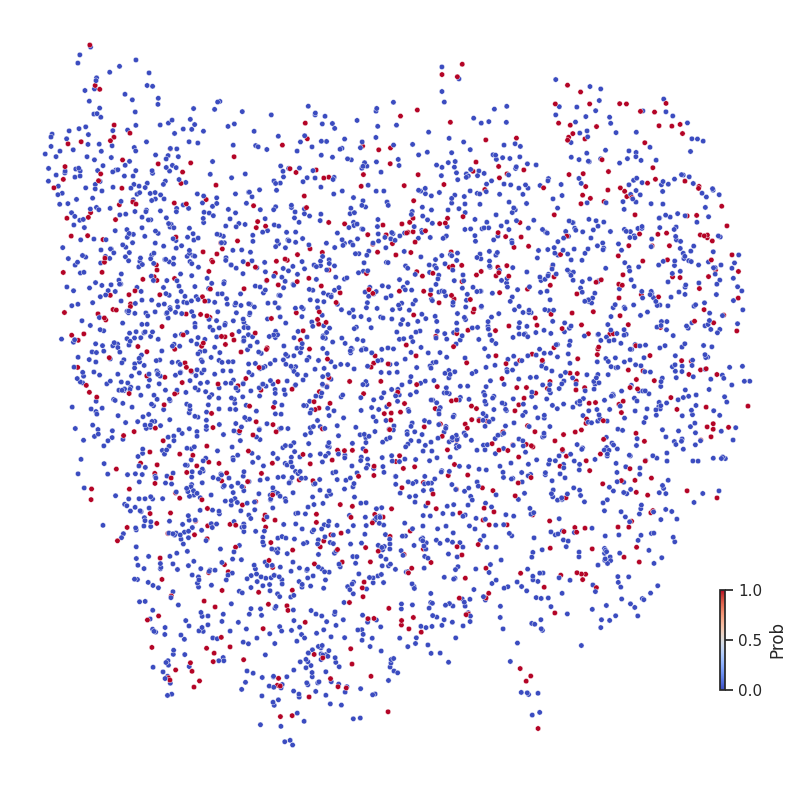

In [93]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

g=sns.scatterplot(x='x',y='y',data=Full_xy,ax=ax,s=15,
                  c=Full_xy.ATG_PPARa_TRANS,cmap='coolwarm',vmin=0,vmax=1,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])
ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
fig.colorbar(sm,ax=ax2,label='Prob')
ax.set_axis_off()
ax2.set_axis_off()

### Tsne

In [104]:
Emb1 = np.concatenate((Emb_full,Emb_tsca))
SID1 = pd.concat((CH_ATG.dsstox_sid.iloc[SID_keep],TSCA1.dtxsid.iloc[SID_tsca]))
len(SID1),Emb1.shape

(16765, (16765, 160))

In [106]:
SID1

0        DTXSID0020232
1        DTXSID0020236
2        DTXSID0020280
3        DTXSID0020282
4        DTXSID0020284
             ...      
13294    DTXSID5064209
13295    DTXSID7062873
13296    DTXSID9040342
13297    DTXSID3044889
13298    DTXSID3060667
Length: 16765, dtype: object

In [108]:
from scipy.spatial.distance import pdist,squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(style='ticks')

tsne = TSNE(n_components=2,perplexity=30.0, random_state=22,verbose=1,
            metric='euclidean',
            learning_rate=0.4,angle=0.5,n_jobs=48)

XY=tsne.fit_transform(Emb1) 
XY= pd.DataFrame(XY,columns=['x','y'])
XY.insert(0,'dtxsid',SID1.tolist())
# Full_xy = XY.merge(CH_ATG.rename(columns=dict(dsstox_sid='dtxsid')),
#                          on='dtxsid')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16765 samples in 0.001s...
[t-SNE] Computed neighbors for 16765 samples in 0.713s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16765
[t-SNE] Computed conditional probabilities for sample 2000 / 16765
[t-SNE] Computed conditional probabilities for sample 3000 / 16765
[t-SNE] Computed conditional probabilities for sample 4000 / 16765
[t-SNE] Computed conditional probabilities for sample 5000 / 16765
[t-SNE] Computed conditional probabilities for sample 6000 / 16765
[t-SNE] Computed conditional probabilities for sample 7000 / 16765
[t-SNE] Computed conditional probabilities for sample 8000 / 16765
[t-SNE] Computed conditional probabilities for sample 9000 / 16765
[t-SNE] Computed conditional probabilities for sample 10000 / 16765
[t-SNE] Computed conditional probabilities for sample 11000 / 16765
[t-SNE] Computed conditional probabilities for sample 12000 / 16765
[t-SNE] Computed conditional probabilities for sam

In [132]:
def leverage(train_set,test_set):
    Ht = test_set.dot(np.linalg.inv(train_set.T.dot(train_set)).dot(test_set.T))
    hat_diag = np.diagonal(Ht)
    return hat_diag
    
Lev_full =pd.DataFrame(dict(dtxsid=CH_ATG.dsstox_sid.iloc[SID_keep],
                           lev=leverage(Emb_full,Emb_full))).set_index('dtxsid') 
Lev_tsca =pd.DataFrame(dict(dtxsid=TSCA1.dtxsid.iloc[SID_tsca],
                           lev=leverage(Emb_full,Emb_tsca))).set_index('dtxsid')
Lev_tsca.head()

,lev
dtxsid,
DTXSID3060164,0.017864
DTXSID7060837,0.101328
DTXSID9025879,0.091227
DTXSID2026282,0.047585
DTXSID4052188,0.016739


In [135]:
LEV = pd.concat((Lev_full.join(pd.DataFrame(dict(src='ATG'),index=
                                            Lev_full.index)),
                 Lev_tsca.join(pd.DataFrame(dict(src='TSCA'),index=
                                            Lev_tsca.index))))


                 
    

/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='lev', ylabel='Density'>

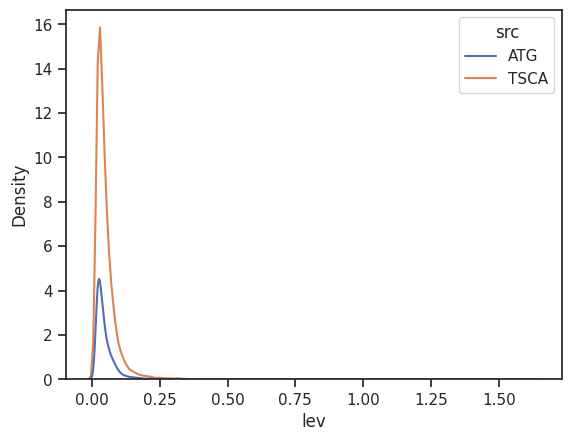

In [143]:
import seaborn as sns

sns.kdeplot(data=LEV,common_norm=True,
            x='lev',hue='src')

In [158]:
L_summ=LEV.groupby('src').aggregate(dict(lev=[np.mean,np.std]))
L_summ.columns=[i+'_'+j for i,j in L_summ.columns]
L_summ.head()

/tmp/ipykernel_146808/2711310249.py:1: FutureWarning: The provided callable <function mean at 0x7f02e85b57e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  L_summ=LEV.groupby('src').aggregate(dict(lev=[np.mean,np.std]))
/tmp/ipykernel_146808/2711310249.py:1: FutureWarning: The provided callable <function std at 0x7f02e85b5900> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  L_summ=LEV.groupby('src').aggregate(dict(lev=[np.mean,np.std]))


,lev_mean,lev_std
src,,
ATG,0.046123,0.037139
TSCA,0.050159,0.049919


In [159]:
LEV.insert(2,'z',(LEV.lev-L_summ.loc['ATG'].lev_mean)/L_summ.loc['ATG'].lev_std)

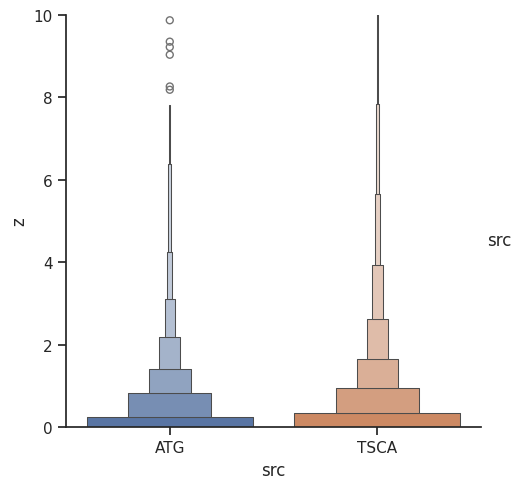

In [165]:
g=sns.catplot(data=LEV,x='src',y='z',hue='src',kind='boxen')
g.set(ylim=[0,10])

In [168]:
LEV[(LEV.src=='TSCA') & (LEV.z<=1)].shape

(11746, 3)

In [147]:
XY_full = CH_ATG.rename(columns=dict(dsstox_sid='dtxsid')).merge(XY[XY.dtxsid.isin(CH_ATG.dsstox_sid)],on='dtxsid')
XY_tsca = TSCA_pred.merge(XY[XY.dtxsid.isin(TSCA1.dtxsid)],on='dtxsid')
XY_tsca.insert(2,'lev',Lev_tsca.loc[XY_tsca.dtxsid].lev.tolist())

In [127]:
XY_tsca.

,dtxsid,name,lev,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,...,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS,x,y
0,DTXSID3060164,Benzhydrylbenzene,0.017864,0.779710,0.078866,0.060122,0.361214,0.688947,0.690899,0.821583,...,0.231312,0.177881,0.402697,0.051371,0.762570,0.165442,0.355170,0.207589,-2.015893,-0.019954
1,DTXSID7060837,"Propane, 1,3-diiodo-",0.101328,0.651144,0.018653,0.016655,0.429287,0.238095,0.091101,0.023027,...,0.042953,0.099048,0.754526,0.009011,0.162233,0.005011,0.009590,0.014180,0.834104,1.605968
2,DTXSID9025879,"3,3'-(p-Phenylene)diacrylic acid",0.091227,0.565440,0.136848,0.003519,0.652231,0.391343,0.058177,0.062860,...,0.018646,0.863138,0.021165,0.020885,0.737458,0.038195,0.169650,0.933103,-1.569027,1.478690
3,DTXSID2026282,C.I. Vat brown 3,0.047585,0.789356,0.178712,0.012944,0.645679,0.689697,0.755852,0.746685,...,0.852921,0.754918,0.073750,0.531950,0.946755,0.223314,0.802305,0.593171,-3.297019,0.699297
4,DTXSID4052188,"2,5,5-Trimethyl-2-phenyl-1,3-dioxane",0.016739,0.604843,0.050259,0.066708,0.290074,0.337627,0.137028,0.729840,...,0.088665,0.037118,0.285498,0.045529,0.570865,0.087767,0.217037,0.209701,-1.381196,-0.924125


<Axes: >

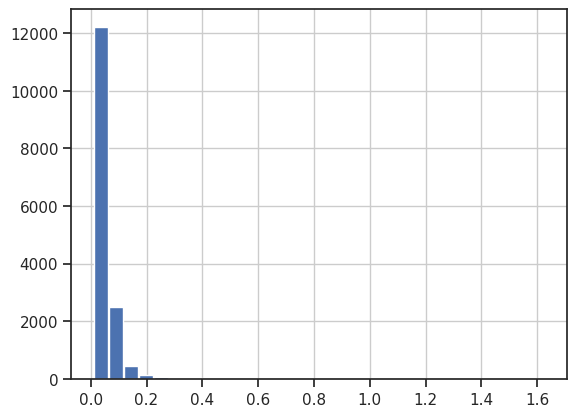

In [130]:
XY_tsca.lev.hist(bins=30,rwidth=0.95)

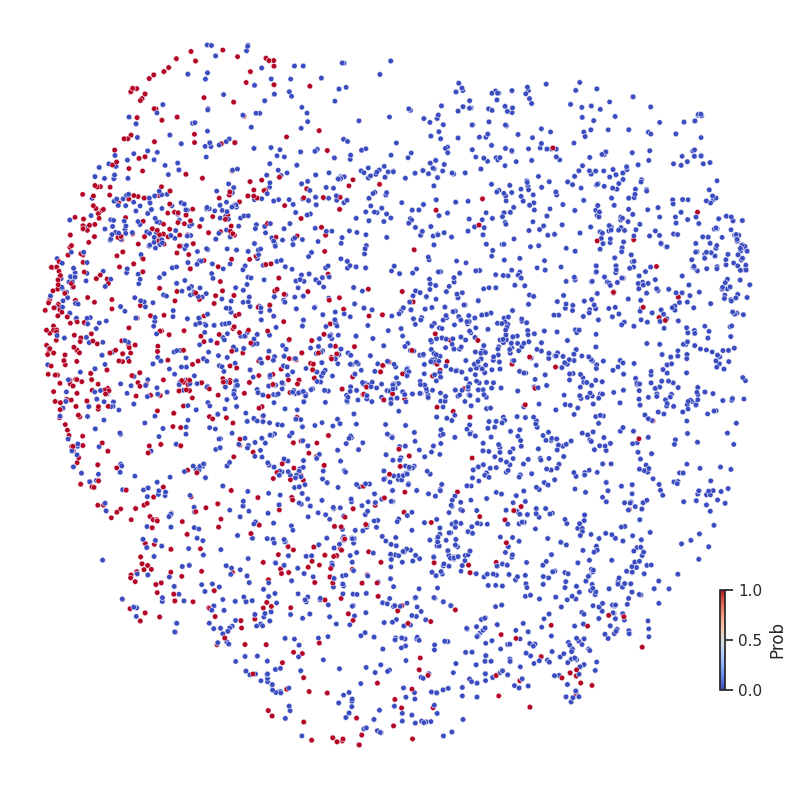

In [128]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

g=sns.scatterplot(x='x',y='y',data=XY_full,ax=ax,s=15,
                  c=XY_full.ATG_PPARa_TRANS,cmap='coolwarm',vmin=0,vmax=1,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])
ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
fig.colorbar(sm,ax=ax2,label='Prob')
ax.set_axis_off()
ax2.set_axis_off()

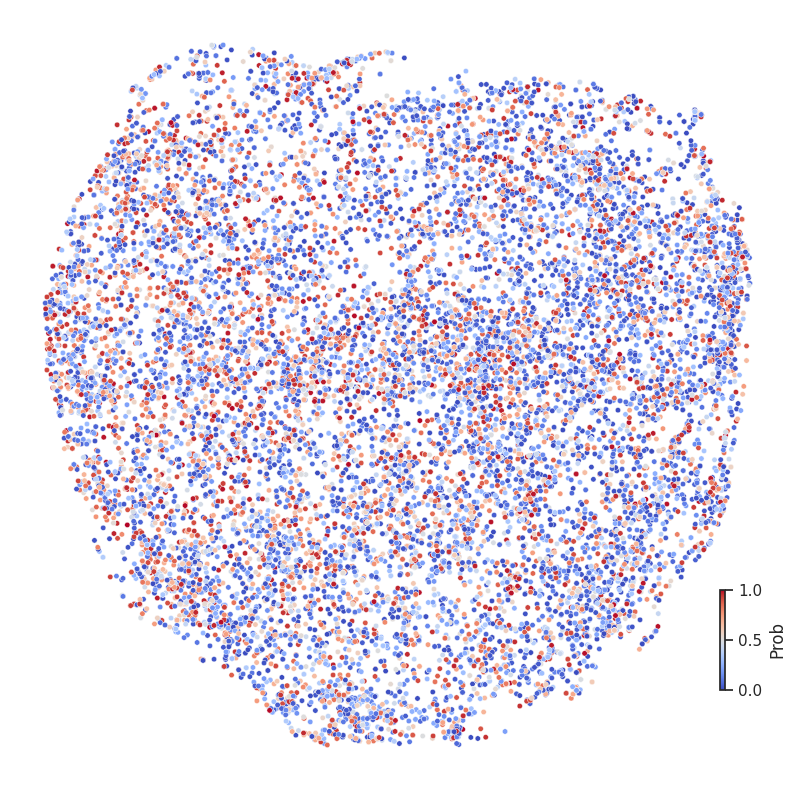

In [116]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

g=sns.scatterplot(x='x',y='y',data=XY_tsca,ax=ax,s=15,
                  c=XY_tsca.ATG_ERa_TRANS,cmap='coolwarm',vmin=0,vmax=1,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])
ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
fig.colorbar(sm,ax=ax2,label='Prob')
ax.set_axis_off()
ax2.set_axis_off()

### Predictions

In [308]:

#len(set(TSCAs.INPUT))
X = TSCA_pred[TSCA_pred.dtxsid.isin(TSCAs.INPUT)]\
        .merge(Lev_tsca.reset_index(),on='dtxsid')\
        .rename(columns=dict(lev='leverage'))
X.to_csv("/home/ishah/ipynb/ml-tox/data/outputs/ATG/atg-afp-tsca-320-pred.csv",index=None)

X = TSCA_pred.merge(Lev_tsca.reset_index(),on='dtxsid')\
        .rename(columns=dict(lev='leverage'))
X.to_csv("/home/ishah/ipynb/ml-tox/data/outputs/ATG/atg-afp-tsca-full-pred.csv",index=None)


In [177]:
TSCA_pred.head()
Pred1 = TSCA_pred.melt(id_vars=['dtxsid','name'],
                       var_name='assay',
                       value_name='pred')
Pred1.insert(3,'pred_label',Pred1.pred.apply(lambda i: 1 if i>0.5 else 0))
Pred1 = Pred1.merge(Lev_tsca.reset_index(),on='dtxsid') 

(1063440, 6)

In [171]:
import re
SelAssay=[i for i in XY_tsca.columns if re.search(r'ROR|AR|LXR|RXR|ER|Ahr|PXR|PPAR|CAR|FXR',i)]
SelAssay1=[i for i in XY_tsca.columns if re.search(r'NF_|Xbp1|NRF|p53|ROR|AR|LXR|RXR|ER|Ahr|PXR|PPAR|CAR|FXR',i)]
SelAssay

['ATG_AR_TRANS',
 'ATG_Ahr_CIS',
 'ATG_CAR_TRANS',
 'ATG_DR4_LXR_CIS',
 'ATG_DR5_RAR_CIS',
 'ATG_ERE_CIS',
 'ATG_ERRa_TRANS',
 'ATG_ERRg_TRANS',
 'ATG_ERa_TRANS',
 'ATG_FXR_TRANS',
 'ATG_LXRa_TRANS',
 'ATG_LXRb_TRANS',
 'ATG_NRF2_ARE_CIS',
 'ATG_PPARa_TRANS',
 'ATG_PPARd_TRANS',
 'ATG_PPARg_TRANS',
 'ATG_PXRE_CIS',
 'ATG_PXR_TRANS',
 'ATG_RARa_TRANS',
 'ATG_RARb_TRANS',
 'ATG_RARg_TRANS',
 'ATG_RORE_CIS',
 'ATG_RORb_TRANS',
 'ATG_RORg_TRANS',
 'ATG_RXRa_TRANS',
 'ATG_RXRb_TRANS']

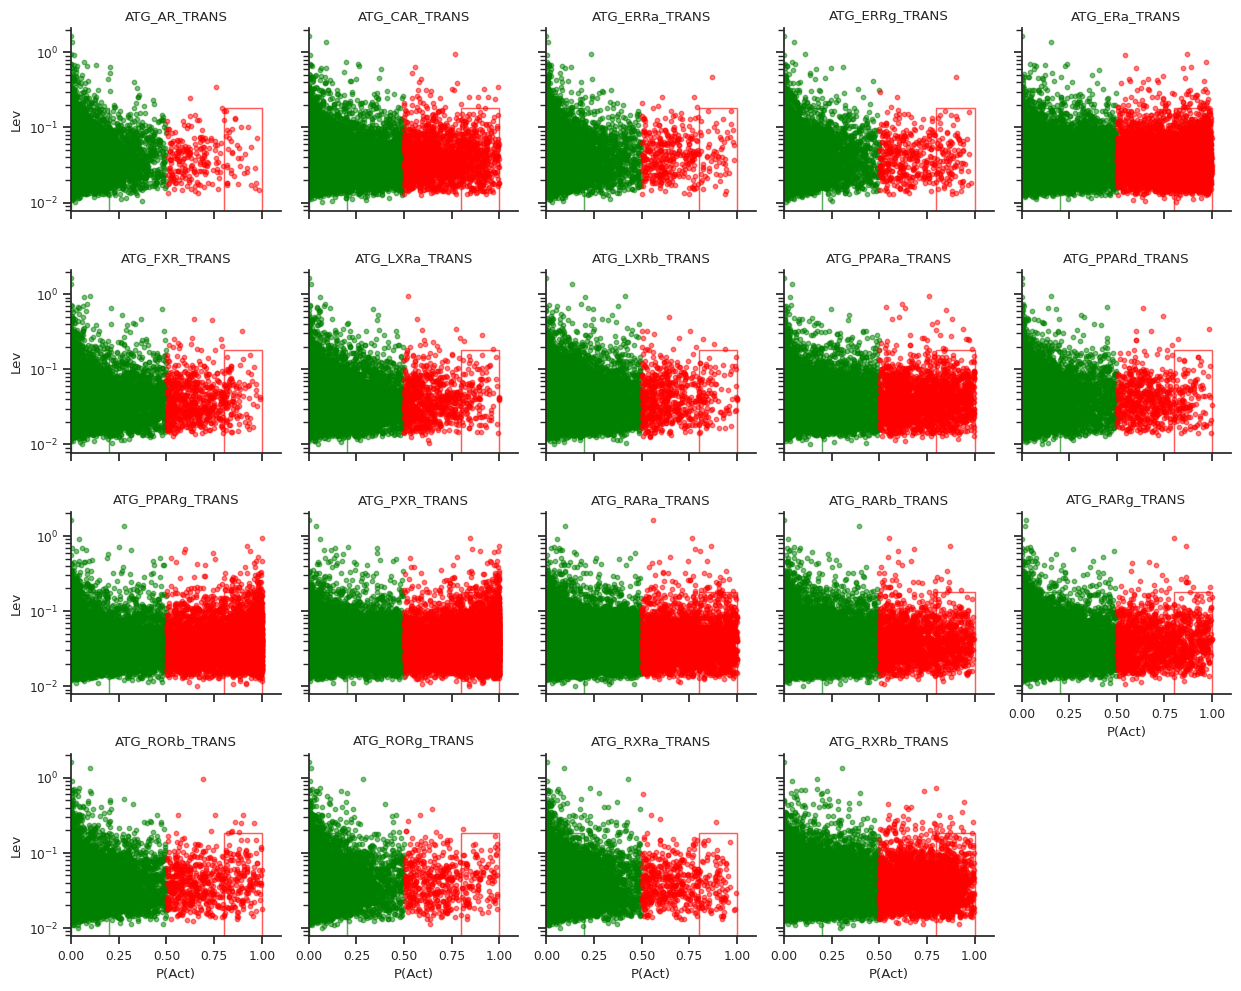

In [178]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 
l0 = 3*(167+1)/2773
SelAssay2 = [i for i in SelAssay if i.find('TRANS')>-1]
Pred2 = Pred1[Pred1.assay.isin(SelAssay2)].dropna()
sns.set(font_scale=0.8,style='ticks')

R1 = [0,0.2,0,l0]
R2 = [0.8,1,0,l0]

def highlight_square(X,Y, **kws):
    ax = pl.gca()
    x1,x2,y1,y2 = kws['rect']
    lw=kws['lw']
    alpha=kws['alpha']
    color=kws['color']
    fill=kws['fill']
    
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=lw, edgecolor=color, 
                             facecolor=color if fill else 'none',alpha=alpha)    
    ax.add_patch(rect)
    # n_pos,n_neg=5,10
    # ax.annotate(r"$n_p$={}\n$n_n$={}".format(n_pos,n_neg),
    #             xy=(.8, 1), size=10,
    #             xycoords=ax.transAxes)

    
g=sns.FacetGrid(Pred2,col='assay',col_wrap=5,
                height=2.5,aspect=1,
                hue='pred_label',
                palette={0:'green',1:'red'},
                legend_out=True)
A,B = 'pred','lev'
g.map(pl.scatter,A,B,s=10,alpha=0.5)
g.map(highlight_square,A,B,color='red',rect=R2,lw=1,alpha=0.4,fill=False)
g.map(highlight_square,A,B,color='green',rect=R1,lw=1,alpha=0.4,fill=False)
#g.map(sns.swarmplot,A,B,s=15,alpha=0.5)
#g.map(corrfunc,A,B)
#g.map(mr2_score,A,B)
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='orange')#,linestyle='--')#,linewidth=0.5,color='grey')


g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xlabel=r'P(Act)',
      yscale='log',
      xlim=[0,1.1],
      ylabel=r'Lev')

g.fig.tight_layout()


In [322]:
Emb_full.shape

(3469, 160)

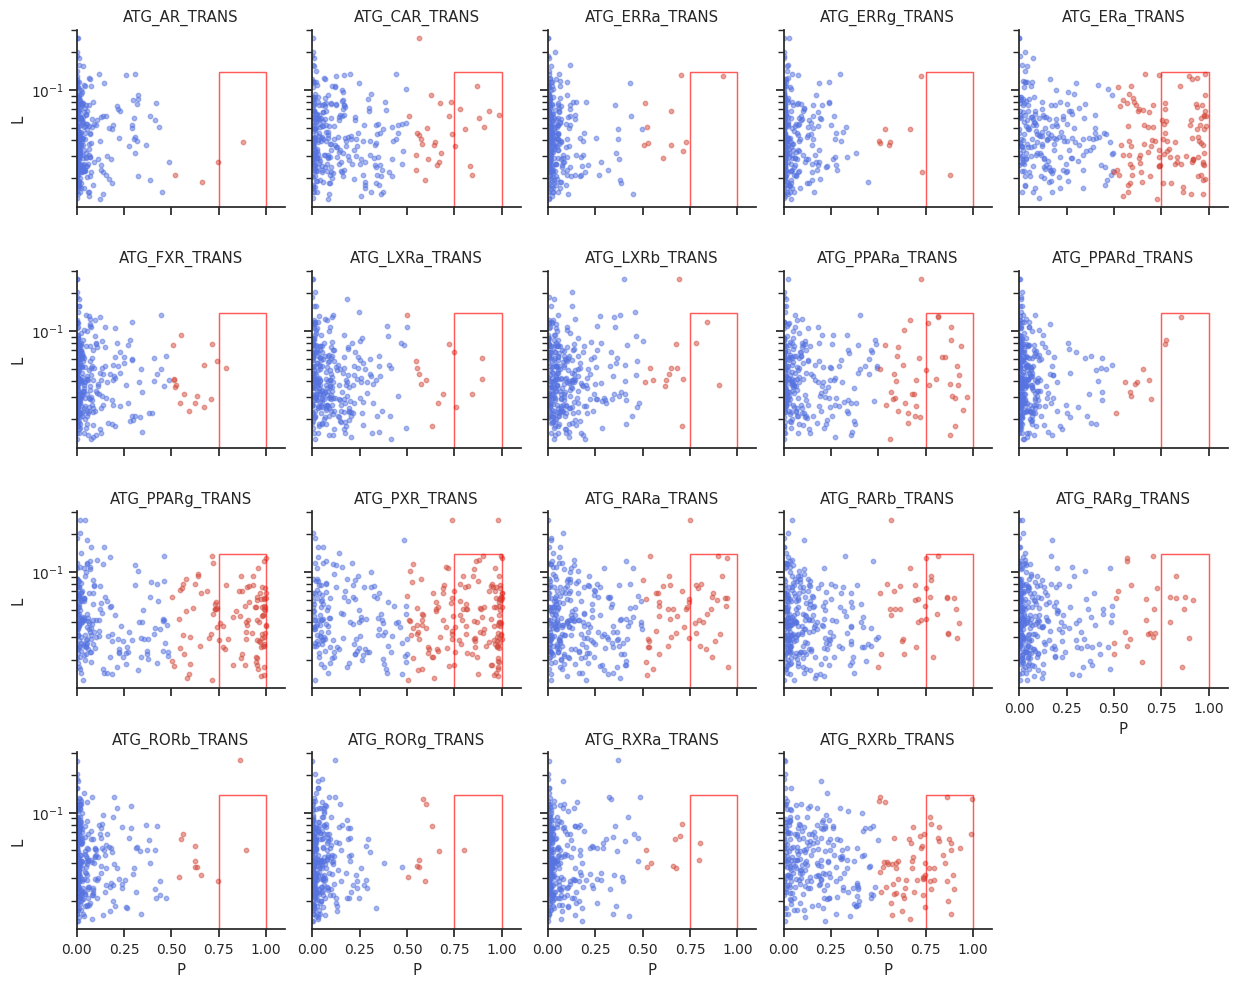

In [339]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 
l0 = 3*(Emb_full.shape[1]+1)/Emb_full.shape[0]
SelAssay2 = [i for i in SelAssay if i.find('TRANS')>-1]
Pred2 = Pred1[Pred1.assay.isin(SelAssay2) & Pred1.dtxsid.isin(TSCAs.INPUT)].dropna()
sns.set(font_scale=0.9,style='ticks')

R1 = [0,0.2,0,l0]
R2 = [0.75,1,0,l0]

def highlight_square(X,Y, **kws):
    ax = pl.gca()
    x1,x2,y1,y2 = kws['rect']
    lw=kws['lw']
    alpha=kws['alpha']
    color=kws['color']
    fill=kws['fill']
    
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=lw, edgecolor=color, 
                             facecolor=color if fill else 'none',alpha=alpha)    
    ax.add_patch(rect)
    # n_pos,n_neg=5,10
    # ax.annotate(r"$n_p$={}\n$n_n$={}".format(n_pos,n_neg),
    #             xy=(.8, 1), size=10,
    #             xycoords=ax.transAxes)

    
g=sns.FacetGrid(Pred2,col='assay',col_wrap=5,
                height=2.5,aspect=1,
                hue='pred_label',
                palette={0:'#5673e0',1:'#d44e41'},
                legend_out=True)
A,B = 'pred','lev'
g.map(pl.scatter,A,B,s=10,alpha=0.5)
g.map(highlight_square,A,B,color='red',rect=R2,lw=1,alpha=0.4,fill=False)
#g.map(highlight_square,A,B,color='blue',rect=R1,lw=1,alpha=0.4,fill=False)
#g.map(sns.swarmplot,A,B,s=15,alpha=0.5)
#g.map(corrfunc,A,B)
#g.map(mr2_score,A,B)
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='orange')#,linestyle='--')#,linewidth=0.5,color='grey')


g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xlabel=r'P',
      yscale='log',
      xlim=[0,1.1],
      ylabel=r'L')

g.fig.tight_layout()


In [324]:
l0

0.13923320841741135

In [ ]:
D = '/home/ishah/ipynb/ml-tox/data/outputs/ATG/'
pd.DataFrame(Full,columns=['x{}'.format(i) for i in range(AFP1_emb.shape[1])]).to_csv(D+'afp1-full-emb.csv',index=None)
Info.to_csv(D+'atg-chm-info.csv',index=None)
All_pred.to_csv(D+'atg-afp-pred.csv',index=None)

In [192]:
TSCAs.shape

(342, 39)

### Positive preds for TSCAS 

In [326]:
Pred3 = Pred1[ (Pred1.dtxsid.isin(TSCAs.INPUT)) & 
               (Pred1.pred>0.75) & (Pred1.lev<l0)]
#Pred1.assay.isin(SelAssay2) &
Pred3.shape

(1692, 6)

Text(0, 0.5, '')

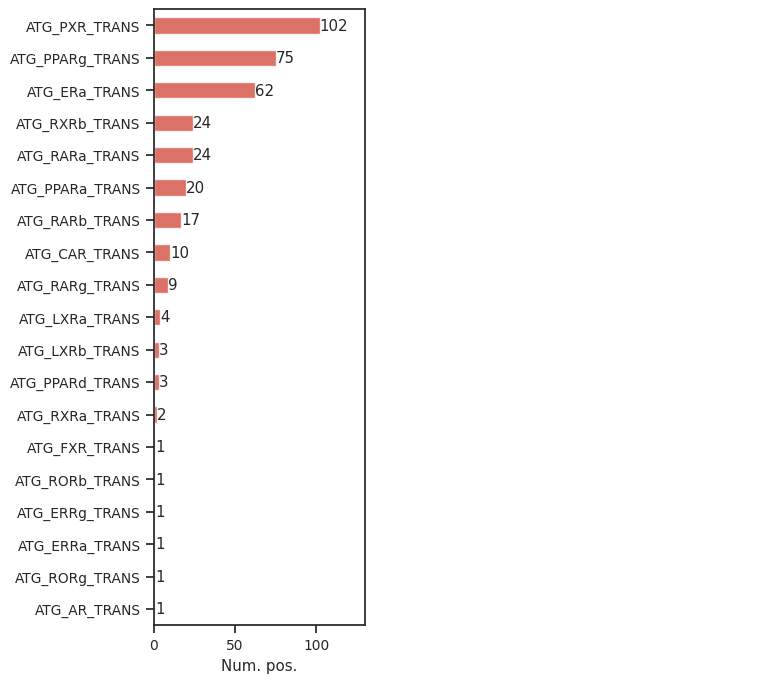

In [343]:
sns.set(font_scale=0.9,style='ticks')

X = Pred3[Pred3.assay.isin(SelAssay2)]
N = X.groupby('assay').aggregate(dict(dtxsid=len))\
            .sort_values('dtxsid')

fig, ax = plt.subplots(figsize=(8,8),
                       nrows=1,ncols=2,
                       width_ratios=[0.3,0.5])
N.plot.barh(ax=ax[0],color='#d44e41',alpha=0.8)
ax[0].legend().set_visible(False)
j=0
for assay,x in N.iterrows():
    ax[0].text(x.dtxsid,j,str(x.dtxsid),ha='left', va='center')
    j+=1
ax[0].set_xlim(0,130)
ax[1].set_axis_off()
ax[0].set_xlabel('Num. pos.')
ax[0].set_ylabel('')


In [232]:
Pred3.sort_values("pred",ascending=False,inplace=True)
Pred3[Pred3.assay.str.contains('PPARa')].head(20)

/tmp/ipykernel_146808/225498451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred3.sort_values("pred",ascending=False,inplace=True)


,dtxsid,name,assay,pred_label,pred,lev
699095,DTXSID9060071,"3-Methyl-1,2-benzenediol",ATG_PPARa_TRANS,1,0.966672,0.029913
700369,DTXSID50893646,"1,3:2,4-Bis-O-[(4-ethylphenyl)methylene]hexitol",ATG_PPARa_TRANS,1,0.947441,0.023526
701742,DTXSID40885792,"Urea, N'-[3-[[[(dimethylamino)carbonyl]amino]m...",ATG_PPARa_TRANS,1,0.934693,0.075728
694808,DTXSID8059217,"Benzene, (methylthio)-",ATG_PPARa_TRANS,1,0.925719,0.044328
691379,DTXSID0064339,"1,3-Benzenediamine, 4-[2-(1-naphthalenyl)diaze...",ATG_PPARa_TRANS,1,0.920053,0.036783
693257,DTXSID101014584,Dipropyl maleate,ATG_PPARa_TRANS,1,0.917063,0.052077
702002,DTXSID6044567,3-(4-Methoxyphenyl)-2-methylpropanal,ATG_PPARa_TRANS,1,0.906236,0.029043
698744,DTXSID9061835,"Tricyclo[8.2.2.24,7]hexadeca-4,6,10,12,13,15-h...",ATG_PPARa_TRANS,1,0.904106,0.017409
701895,DTXSID6065923,"Thiazole, 2-ethyl-4-methyl-",ATG_PPARa_TRANS,1,0.891267,0.030527
695366,DTXSID0051780,Triethylene glycol diacrylate,ATG_PPARa_TRANS,1,0.886143,0.106935


# #xport

In [310]:
Emb1.shape, 

((16765, 160), (3479, 1))

## Neighbours of hits

In [261]:
from sklearn.neighbors import NearestNeighbors

NN = NearestNeighbors(n_neighbors=100,metric='euclidean')
NN.fit(Emb1)
Dist,Ind = NN.kneighbors()


In [241]:
Ind.shape,Dist.shape,Emb1.shape,len(SID1)

((16765, 25), (16765, 25), (16765, 160), 16765)

In [263]:
I=pd.Index(SID1)
Emb1_nn = pd.DataFrame([I[x] for x in Ind])
Emb1_nn.index = SID1
Emb1_nn.columns=['nn_{}'.format(i) for i in range(1,101)]

Dist_nn = pd.DataFrame(Dist)
Dist_nn.index = SID1
Dist_nn.columns=['nn_{}'.format(i) for i in range(1,101)]


#### Diethylmaleate


In [255]:
ATG = CHM.reset_index().merge(CH_ATG,on='dsstox_sid')

In [298]:
sid = 'DTXSID9060071'
C1 = ['dsstox_sid','name']+ATG.columns[ATG.columns.str.contains('PPAR')].tolist()
NN1 = Emb1_nn.loc[sid]
Neig1 = ATG.loc[ATG.dsstox_sid.isin(NN1),C1]
NN2 = NN1[NN1.isin(Neig1.dsstox_sid)]

In [ ]:
D1 = Dist_nn.loc[sid,NN2.index]
Neig1.insert(1,'D',D1.tolist())

In [297]:
Neig1.shape,D1.shape,NN2.shape

((29, 5), (56,), (56,))

In [292]:
len(set(NN1).intersection(Neig1.dsstox_sid))

29

In [65]:
from functools import reduce

Neg_nn=set(reduce(lambda x,y: x+y,AFP1_emb_nn.loc[SID_neg].iloc[:,:5].apply(lambda x: x.tolist(),axis=1).tolist()))

In [66]:
def classify(x):
    ret = ''
    if x.ERa_TRANS_pred_bin==1 and x.er_class==1:
        ret = 'TP'
    elif x.ERa_TRANS_pred_bin==1 and x.er_class==0:
        ret = 'FP'
    elif x.ERa_TRANS_pred_bin==0 and x.er_class==1:
        ret = 'FN'
    elif x.ERa_TRANS_pred_bin==0 and x.er_class==0:
        ret = 'TN'

    return ret

(-11.131611824035645, 9.985713005065918)

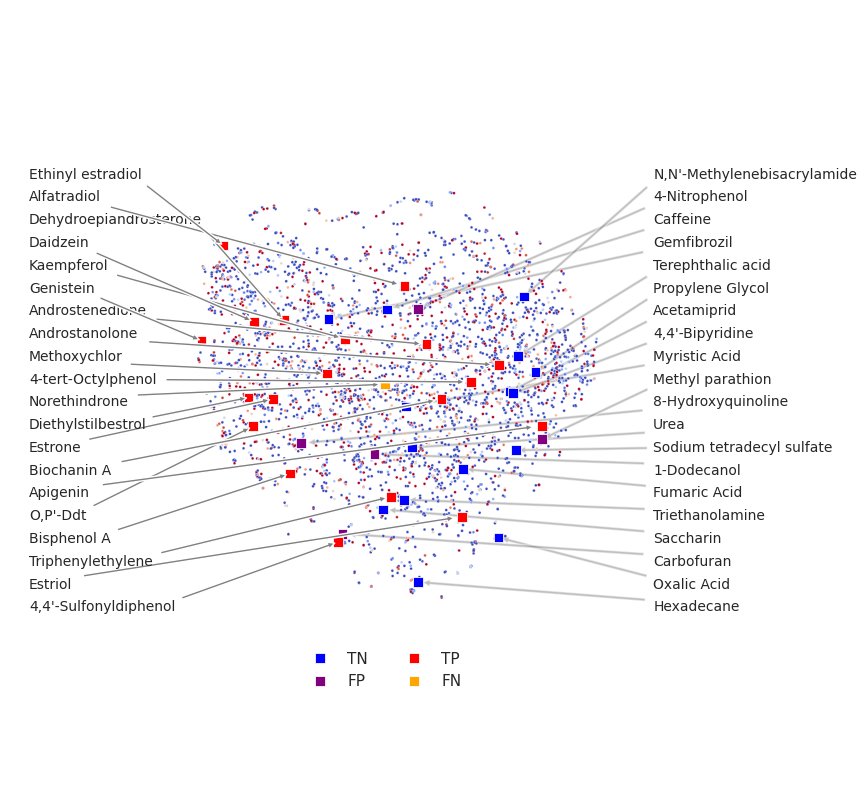

In [91]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

# g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=5,
#                   c='grey',legend=False)
g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=4,
                  c=ER_pred1.ERa_TRANS_pred,cmap='coolwarm',vmin=0.2,vmax=0.8,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])


X1_pos = ER_pred1[ER_pred1.dtxsid.isin(SID_pos)]\
            .drop([ 'ERa_TRANS_pred', 'ERE_CIS_pred'],axis=1)\
            .merge(ER_pred,on='dtxsid')

# g=sns.scatterplot(x='x',y='y',data=X1_pos,ax=ax,s=50,
#                   c='red',legend=False)

xmin,xmax=ER_pred1.x.min(),ER_pred1.x.max()
ymin,ymax=ER_pred1.y.min(),ER_pred1.y.max()

dy = (ymax+12-ymin-10)/(X1_pos.shape[0]+1)
y  = ymin-1
x  = xmin-9
for i,Ci in X1_pos.sort_values('y').iterrows():
    y+=dy
    ax.annotate(Ci.chemical,xy=(Ci.x,Ci.y),xytext=(x,y),
                font=dict(size=10),
                arrowprops=dict(facecolor='grey',shrink=0.02,width=2,
                                headwidth=5,headlength=5))
    
    
X1_neg = ER_pred1[ER_pred1.dtxsid.isin(SID_neg)]\
            .drop([ 'ERa_TRANS_pred', 'ERE_CIS_pred'],axis=1)\
            .merge(ER_pred,on='dtxsid')

y  = ymin-1
x  = xmax+3
for i,Ci in X1_neg.sort_values('y').iterrows():
    y+=dy
    ax.annotate(Ci.chemical,xy=(Ci.x,Ci.y),xytext=(x,y),
                font=dict(size=10),zorder=0,
                arrowprops=dict(facecolor='grey',shrink=0.02,width=2,
                                headwidth=5,headlength=5,alpha=0.5))
X1 = pd.concat((X1_neg,X1_pos))
X1.insert(X1.shape[1],'Pred',X1.apply(classify,axis=1))
g=sns.scatterplot(x='x',y='y',data=X1,ax=ax,s=50,marker='s',
                  hue=X1.Pred,palette=dict(TP='red',TN='blue',FP='purple',FN='orange'))


sns.move_legend(
    g, "lower right",ncol=2, title="", frameon=False,
    bbox_to_anchor=(.6, 0.1), 
)
# ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
ax.set_axis_off()
# ax2.set_axis_off()

ax.set_xlim(xmin-10,xmax+10)
ax.set_ylim(ymin-5,ymax+5)



/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


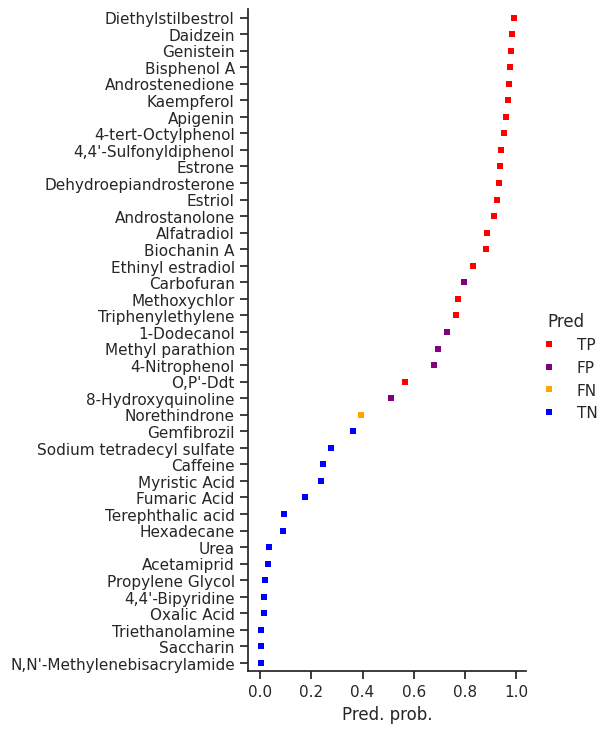

In [87]:
import seaborn as sns
sns.set(style='ticks')
g=sns.catplot(data=X1.sort_values('ERa_TRANS_pred',ascending=False),x='ERa_TRANS_pred',y='chemical',
            hue='Pred',palette=dict(TP='red',TN='blue',FP='purple',FN='orange'),
              marker='s',
            aspect=0.8,height=7.5)
                  
g.set(xlabel='Pred. prob.',ylabel='')

In [238]:
ERP1 = ER_pred.set_index('dtxsid')

AFP1_emb_nn.loc[SID_pos+SID_neg].iloc[:,:5].apply(lambda x: CHM.loc[x].name.tolist(),axis=1)

dtxsid
DTXSID8022377    [Sodium xylenesulfonate, Octyl decyl phthalate...
DTXSID3020465    [Asulam, 2-Nitrotoluene, 1-Naphthalenesulfonic...
DTXSID5022308    [Digitoxin, Ouabain, SR144190, Triethylene gly...
DTXSID7020182    [4-Methyl-1-(propan-2-yl)cyclohex-3-en-1-ol, N...
DTXSID5020576    [Isopropyl-o-cresol, 3-Hydroxypropanenitrile, ...
DTXSID9022310    [Thiophanate-methyl, C.I. Acid Yellow 11, sodi...
DTXSID4022367    [Glycoluril, n-Undecyl cyanide, (R)-2-(4-Chlor...
DTXSID9022364    [Prodiamine, Methidathion, 2-Benzyl-2-(dimethy...
DTXSID9022366    [Cytosine, 2,6-Di-tert-butyl-4-[(dimethylamino...
DTXSID8024523    [1,3-Dihydro-2H-inden-2-one, (2-Nitro-1-propen...
DTXSID0025816    [Hexadecanoic acid, 3-Phenylhexane, Tolbutamid...
DTXSID0021206    [1,2,4,5-Tetrachlorobenzene, 1-Phenylurea, C.I...
DTXSID6021666    [Ethylene glycol dimethacrylate, 3,3',5,5'-Tet...
DTXSID0020232    [1,6-Hexanediol diacrylate, 4-Chlorobenzopheno...
DTXSID5021251    [2,4-Dichlorophenoxyacetic acid, Chlor

In [239]:
AFP1_emb_nn.loc[SID_pos].iloc[:,:5].apply(lambda x: CHM.loc[x].name.tolist(),axis=1)

dtxsid
DTXSID8022377    [Sodium xylenesulfonate, Octyl decyl phthalate...
DTXSID3020465    [Asulam, 2-Nitrotoluene, 1-Naphthalenesulfonic...
DTXSID5022308    [Digitoxin, Ouabain, SR144190, Triethylene gly...
DTXSID7020182    [4-Methyl-1-(propan-2-yl)cyclohex-3-en-1-ol, N...
DTXSID5020576    [Isopropyl-o-cresol, 3-Hydroxypropanenitrile, ...
DTXSID9022310    [Thiophanate-methyl, C.I. Acid Yellow 11, sodi...
DTXSID4022367    [Glycoluril, n-Undecyl cyanide, (R)-2-(4-Chlor...
DTXSID9022364    [Prodiamine, Methidathion, 2-Benzyl-2-(dimethy...
DTXSID9022366    [Cytosine, 2,6-Di-tert-butyl-4-[(dimethylamino...
DTXSID8024523    [1,3-Dihydro-2H-inden-2-one, (2-Nitro-1-propen...
dtype: object

In [311]:
len(SID_keep)

3469

In [290]:
Test=AFP1_emb[np.where(ER_pred0.dtxsid.isin(SID_pos+SID_neg))]
Train=AFP1_emb[np.where(~ER_pred0.dtxsid.isin(SID_pos+SID_neg))]
p = Train.shape[1]
n = Train.shape[0]
l0 = 3*(p/n)

Test.shape,Train.shape,l0

((20, 160), (3449, 160), 0.13917077413743115)

In [291]:
DA1=pd.DataFrame(dict(dtxsid=SID_pos+SID_neg,lvg=leverage(Train,Test)))
DA1.insert(2,'in_domain',DA1.lvg<l0)
DA1

,dtxsid,lvg,in_domain
0,DTXSID8022377,0.079394,True
1,DTXSID3020465,0.067800,True
2,DTXSID5022308,0.059542,True
3,DTXSID7020182,0.038154,True
4,DTXSID5020576,0.017708,True
5,DTXSID9022310,0.015841,True
6,DTXSID4022367,0.066544,True
7,DTXSID9022364,0.030537,True
8,DTXSID9022366,0.059158,True
9,DTXSID8024523,0.033963,True


<Axes: >

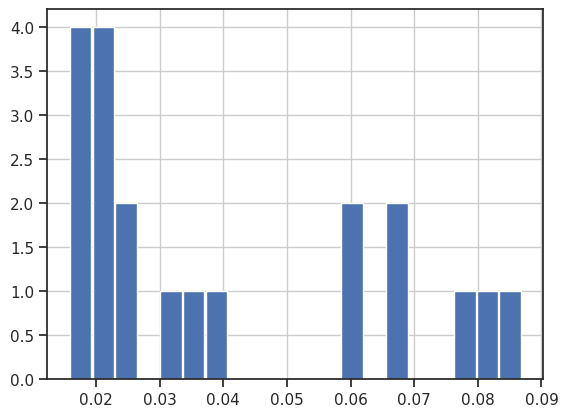

In [294]:
DA1.lvg.hist(bins=20,rwidth=0.95)